In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [160]:
df = pd.read_excel("C://Users//LENOVO//Downloads//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
date,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [161]:
data = df.loc[(df['kode_des']==431)]
data = pd.DataFrame(data)
logic = {'y': 'sum'}
data = data.resample('W-SUN').apply(logic)
data

,y
date,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


In [162]:
n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
date                   
2022-12-18  858652051.0
Min - Max Value : 0.0 - 829809500.0


,y
date,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


In [163]:
logic = {'y': 'sum'}
data = data.loc[data.y>0.0].resample('W-SUN').apply(logic)
data = data.reset_index().rename(columns={'index': 'date'})
data = data.rename(columns={'date': 'ds'})
data


,ds,y
0,2020-11-22,21891600.0
1,2020-11-29,82167900.0
2,2020-12-06,25570700.0
3,2020-12-13,33002000.0
4,2020-12-20,81230000.0
...,...,...
120,2023-03-12,589943335.0
121,2023-03-19,142535977.0
122,2023-03-26,785915116.0
123,2023-04-02,250352469.0


In [137]:
# print(f"start date: {min(data.index)}, end date: {max(data.index)}")
# data = data.loc[data.y>0.0].asfreq('W-SUN')
# data = data.interpolate(method='linear')
# data = data.astype({'y':'int'})
# # data = data.astype({'y':'int'})
# print(f'Number of rows with missing values: {data.isnull().mean()}')
# data

In [164]:
len(data.loc[data.y==0])

3

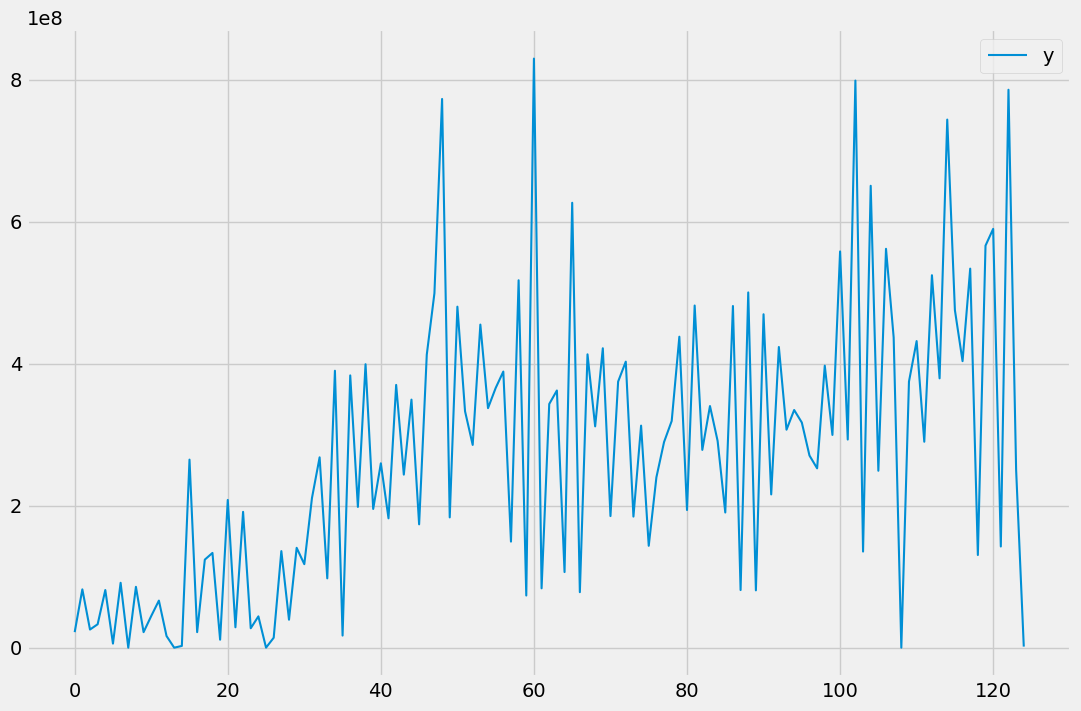

In [31]:
revenue_plot =data['y'].plot(
    figsize=(12,8),
    legend=True,
)

In [86]:
# unscaled = data['y'].values.reshape(len(data['y']),1)
# scaler = MinMaxScaler(feature_range=(0, 5))
# scaler.fit(unscaled)
# scaled = scaler.transform(unscaled)
# data['y'] = scaled
# data['y']

In [32]:
unscaled = data['y'].values.reshape(len(data['y']),1)
scaler = StandardScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
data['y'] = scaled
data['y']

0     -1.263242
1     -0.959406
2     -1.244696
3     -1.207237
4     -0.964133
         ...   
120    1.600146
121   -0.655107
122    2.587985
123   -0.111635
124   -1.365979
Name: y, Length: 125, dtype: float64

In [ ]:
# data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
# data['y']

Train dates : 0 --- 112  (n=113)
Test dates  : 113 --- 124  (n=12)


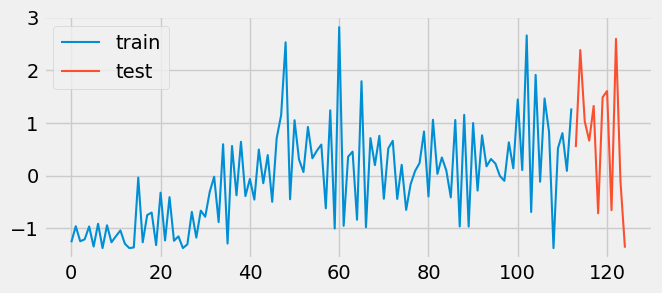

In [158]:
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

# ARIMA

In [137]:
import warnings
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 3)

# Ignore the convergence warnings
warnings.filterwarnings("ignore")

# Grid search over all combinations of p, d, and q
best_rmse, best_order = float('inf'), None
for p, d, q in itertools.product(p_values, d_values, q_values):
        print(p,d,q)

        # Fit the ARIMA model to the training data
        model = ARIMA(data_train['y'].values,order=(p,q,d))
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
        predictions.index = data_test.index


        # Calculate the RMSE of the predictions
        rmse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )
        print(rmse)

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

0 0 0
2.0710521513325384
0 0 1
1.7168970058627604
0 0 2
89.32265992854387
0 1 0
2.065518283678823
0 1 1
1.4569090330434153
0 1 2
1.9720966988807491
0 2 0
2.0319997885414276
0 2 1
1.4974332350322948
0 2 2
1.4064606867692904
1 0 0
2.053888658563899
1 0 1
1.3981752664560407
1 0 2
7.839694608832251
1 1 0
1.4847284439201867
1 1 1
1.4345358692348447
1 1 2
1.468239490301504
1 2 0
1.5402814078731877
1 2 1
1.4374742791505912
1 2 2
1.444344060522102
2 0 0
1.5865980352539648
2 0 1
1.3671011180236092
2 0 2
2.3015016308722918
2 1 0
1.4622807996378182
2 1 1
1.4362301388893703
2 1 2
1.4182718225469593
2 2 0
1.4642924232710766
2 2 1
1.4209802039464983
2 2 2
1.4443069710273881
3 0 0
1.4218234153474973
3 0 1
1.3738951158103514
3 0 2
4.675519625924
3 1 0
1.4632933499737832
3 1 1
1.4029734769438507
3 1 2
1.423510886781154
3 2 0
1.446291933586142
3 2 1
1.4122959946040547
3 2 2
1.4175621816424027
4 0 0
1.421755739381809
4 0 1
1.5373313508697208
4 0 2
4.943801885370526
4 1 0
1.4235278076419726
4 1 1
1.519697

In [138]:
print(best_rmse,(best_order))
arima_model = ARIMA(data_train['y'].values,order=(best_order))
arima_results = arima_model.fit()
# Output model summary results:
arima_results.summary()

1.3671011180236092 (2, 0, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -112.290
Date:                Tue, 02 May 2023   AIC                            234.581
Time:                        14:06:28   BIC                            248.218
Sample:                             0   HQIC                           240.114
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1690      0.544     -0.311      0.756      -1.235       0.897
ar.L1          0.3296      0.094      3.494      0.000       0.145       0.515
ar.L2          0.6304      0.077      8.146      0.000       0.479       0.782
ma.L1         -0.6105      0.087     -7.005      0.000      -0.781      -0.440
sigma2         0.4200      0.039     10.753      0.000       0.343       0.497
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
y_pred = arima_results.forecast(steps=steps)
print(y_pred)

[-0.01705869  0.78886286  0.24252247  0.57046151  0.33416307  0.4629951
  0.35650635  0.40261635  0.35068815  0.3626374   0.33384218  0.33188282]


In [140]:
predictions = pd.DataFrame(y_pred,columns=['prediction'])
predictions.index = data_test.index
predictions

,prediction
113,-0.017059
114,0.788863
115,0.242522
116,0.570462
117,0.334163
118,0.462995
119,0.356506
120,0.402616
121,0.350688
122,0.362637


In [142]:
from statsmodels.tools.eval_measures import rmse
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions['prediction'],data_test['y']))
print("Mean Value of Test Dataset:", data_test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  1.2092480306528592
Mean Value of Test Dataset: 0.728189855600403


In [143]:
data_test['y'] = scaler.inverse_transform(data_test['y'].values.reshape(len(data_test['y']),1))
data_test = data_test.astype({'y':'int'})
data_test['y']

113    379405100
114    743895601
115    475520763
116    403625941
117    533947948
118    130531956
119    566343946
120    589943335
121    142535977
122    785915116
123    250352469
124      1510000
Name: y, dtype: int32

In [144]:
predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
predictions = predictions.astype({'prediction':'int'})
predictions['prediction']

113    269114934
114    428997261
115    320611807
116    385669823
117    338791879
118    364350155
119    343224440
120    352371947
121    342070200
122    344440746
123    338728220
124    338339514
Name: prediction, dtype: int32

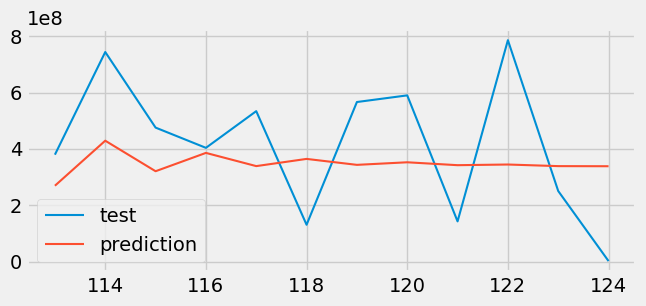

In [145]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [146]:
# Test error
# ==============================================================================
from statsmodels.tools.eval_measures import rmse
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions['prediction'],data_test['y']))
print("Mean Value of Test Dataset:", data_test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  nan
Mean Value of Test Dataset: 416960679.3333333


# PROPHET

In [148]:
model = Prophet()
model.fit(data_train)

14:06:54 - cmdstanpy - INFO - Chain [1] start processing
14:06:54 - cmdstanpy - INFO - Chain [1] done processing


In [149]:
future = model.make_future_dataframe(periods=len(data_test),freq='W-SUN')

In [150]:
forecast = model.predict(future)

In [151]:
forecast.tail() #yhat itu prediksi nya

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
120,2023-03-12,0.910645,-0.025767,1.839093,0.910592,0.910702,0.054798,0.054798,0.054798,0.054798,0.054798,0.054798,0.0,0.0,0.0,0.965443
121,2023-03-19,0.926042,0.003201,1.880693,0.925981,0.926112,0.031254,0.031254,0.031254,0.031254,0.031254,0.031254,0.0,0.0,0.0,0.957296
122,2023-03-26,0.941440,-0.040603,1.900194,0.941367,0.941521,-0.029174,-0.029174,-0.029174,-0.029174,-0.029174,-0.029174,0.0,0.0,0.0,0.912267
123,2023-04-02,0.956838,-0.056247,1.795814,0.956753,0.956934,-0.068507,-0.068507,-0.068507,-0.068507,-0.068507,-0.068507,0.0,0.0,0.0,0.888331
124,2023-04-09,0.972236,-0.014461,1.871179,0.972138,0.972350,-0.070566,-0.070566,-0.070566,-0.070566,-0.070566,-0.070566,0.0,0.0,0.0,0.901670


In [152]:
prediction = forecast.iloc[-len(data_test):]['yhat']
predictions = pd.DataFrame(prediction)
predictions

,yhat
113,0.906767
114,0.735327
115,0.625156
116,0.624098
117,0.700873
118,0.808620
119,0.909150
120,0.965443
121,0.957296
122,0.912267


In [153]:
from statsmodels.tools.eval_measures import rmse
print("Root Mean Squared Error between actual and  predicted values: ",rmse(prediction,data_test['y']))
print("Mean Value of Test Dataset:", data_test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  1.2237847220030276
Mean Value of Test Dataset: 0.728189855600403


In [154]:
data_test['y'] = scaler.inverse_transform(data_test['y'].values.reshape(len(data_test['y']),1))
data_test['y']

113    379405100.0
114    743895601.0
115    475520763.0
116    403625941.0
117    533947948.0
118    130531956.0
119    566343946.0
120    589943335.0
121    142535977.0
122    785915116.0
123    250352469.0
124      1510000.0
Name: y, dtype: float64

In [155]:
predictions['yhat'] = scaler.inverse_transform(predictions['yhat'].values.reshape(len(predictions['yhat']),1))
predictions = predictions.astype({'yhat':'int'})
predictions['yhat']

113    452387515
114    418376651
115    396520405
116    396310475
117    411541375
118    432916816
119    452860429
120    464028003
121    462411804
122    453478635
123    448730279
124    451376508
Name: yhat, dtype: int32

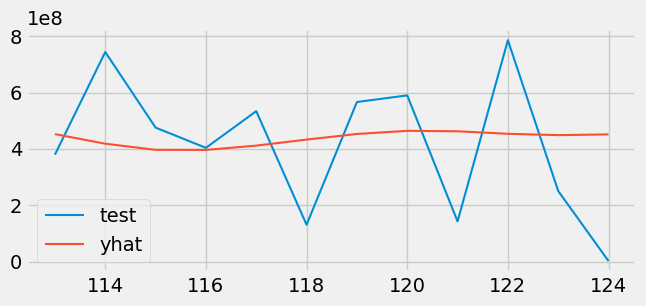

In [156]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['yhat'].plot(ax=ax, label='yhat')
ax.legend();

In [133]:
from statsmodels.tools.eval_measures import rmse
print("Root Mean Squared Error between actual and  predicted values: ",rmse(prediction,data_test['y']))
print("Mean Value of Test Dataset:", data_test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  457971800.0350319
Mean Value of Test Dataset: 354051379.4


# Step Sesuai Kasus

In [125]:
data = df.loc[(df['kode_des']==431)]
data = pd.DataFrame(data)
logic = {'y': 'sum'}
data = data.resample('W-SUN').apply(logic)

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
date                   
2022-12-18  858652051.0
Min - Max Value : 0.0 - 829809500.0


,y
date,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


In [126]:
logic = {'y': 'sum'}
data = data.loc[data.y>0.0].resample('W-SUN').apply(logic)
data

,y
date,
2020-11-22,21891600.0
2020-11-29,82167900.0
2020-12-06,25570700.0
2020-12-13,33002000.0
2020-12-20,81230000.0
...,...
2023-03-12,589943335.0
2023-03-19,142535977.0
2023-03-26,785915116.0


In [112]:
# unscaled = data['y'].values.reshape(len(data['y']),1)
# scaler = StandardScaler()
# scaler.fit(unscaled)
# scaled = scaler.transform(unscaled)
# data['y'] = scaled
# data['y']

date
2020-11-22   -1.263242
2020-11-29   -0.959406
2020-12-06   -1.244696
2020-12-13   -1.207237
2020-12-20   -0.964133
                ...   
2023-03-12    1.600146
2023-03-19   -0.655107
2023-03-26    2.587985
2023-04-02   -0.111635
2023-04-09   -1.365979
Freq: W-SUN, Name: y, Length: 125, dtype: float64

In [127]:
today_with_timestamp = datetime.datetime.combine(datetime.date.today(), datetime.time.min)
max_date = data.index.max()
new_row = pd.DataFrame({'date': today_with_timestamp, 'y': [None], 'org': [None], 'kode_org': [None], 'des': [None], 'kode_des': [None]})
new_row = new_row.set_index('date')
data_steps = pd.concat([data, new_row], axis=0)
data_steps = data_steps.asfreq('W-SUN')
steps = len(data_steps)-len(data)
steps

3

Train dates : 2020-11-22 00:00:00 --- 2023-03-19 00:00:00  (n=122)
Test dates  : 2023-03-26 00:00:00 --- 2023-04-09 00:00:00  (n=3)


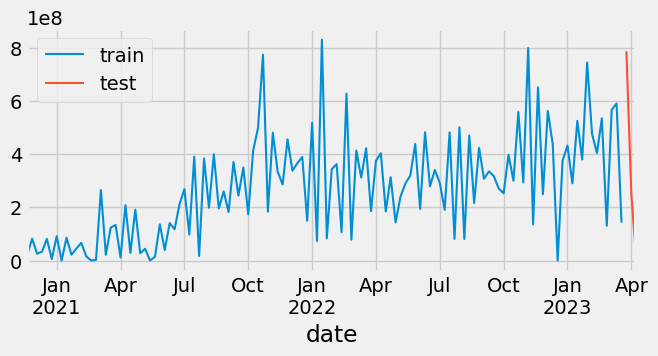

In [128]:
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [129]:
import warnings
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 3)

# Ignore the convergence warnings
warnings.filterwarnings("ignore")

# Grid search over all combinations of p, d, and q
best_rmse, best_order = float('inf'), None
for p, d, q in itertools.product(p_values, d_values, q_values):
        print(p,d,q)

        # Fit the ARIMA model to the training data
        model = ARIMA(data_train['y'].values,order=(p,q,d))
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
        predictions.index = data_test.index


        # Calculate the RMSE of the predictions
        rmse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )
        print(rmse)

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

0 0 0
1.1277560362075584e+17
0 0 1
1.4848314621212397e+17
0 0 2
1.2126521949137016e+18
0 1 0
1.1583604305371646e+17
0 1 1
1.1071565586248645e+17
0 1 2
1.4914186769613565e+17
0 2 0
6.406220515471305e+16
0 2 1
9.139540762733872e+16
0 2 2
1.1204068638555456e+17
1 0 0
1.1862436958559486e+17
1 0 1
9.272604159710187e+16
1 0 2
3.054569085079294e+17
1 1 0
1.084986559633236e+17
1 1 1
9.052818977228928e+16
1 1 2
9.406317893584376e+16
1 2 0
8.33643441526454e+16
1 2 1
9.265860863307554e+16
1 2 2
9.455240128016589e+16
2 0 0
8.557816973455635e+16
2 0 1
8.401748299534155e+16
2 0 2
8.238724335401171e+16
2 1 0
8.650061123095349e+16
2 1 1
9.472705948895019e+16
2 1 2
8.744659702765165e+16
2 2 0
8.78063996054589e+16
2 2 1
8.685001755375499e+16
2 2 2
1.0122080221697894e+17
3 0 0
7.399056937474872e+16
3 0 1
8.262280787270984e+16
3 0 2
7.634884941371106e+16
3 1 0
8.99837136872057e+16
3 1 1
8.66046211942582e+16
3 1 2
8.639210153157422e+16
3 2 0
8.134321133357963e+16
3 2 1
9.61451260873956e+16
3 2 2
9.35455704

In [118]:
print(best_rmse,(best_order))
arima_model = ARIMA(data_train['y'].values,order=(best_order))
arima_results = arima_model.fit()
# Output model summary results:
arima_results.summary()

1.6277788666618864 (0, 2, 0)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -276.776
Date:                Tue, 02 May 2023   AIC                            555.553
Time:                        13:31:41   BIC                            558.340
Sample:                             0   HQIC                           556.685
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.9006      0.697      8.467      0.000       4.535       7.267
===================================================================================
Ljung-Box (L1) (Q):                  88.53   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.00   Prob(JB):                         0.68
Heteroskedasticity (H):               3.85   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
y_pred = arima_results.forecast(steps=steps)
print(y_pred)

[-2.9103612  -5.16561503 -7.42086885]


In [131]:
predictions = pd.DataFrame(y_pred,columns=['prediction'])
predictions.index = data_test.index
predictions

,prediction
date,
2023-03-26,-2.910361
2023-04-02,-5.165615
2023-04-09,-7.420869


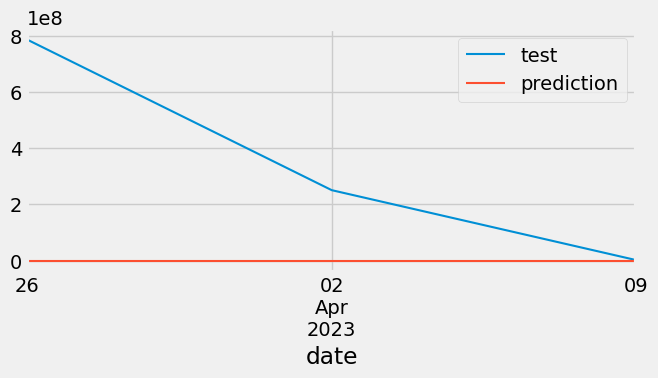

In [132]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [122]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 30.81206953357899


In [123]:
data_test['y'] = scaler.inverse_transform(data_test['y'].values.reshape(len(data_test['y']),1))
data_test['y']

date
2023-03-26    785915116.0
2023-04-02    250352469.0
2023-04-09      1510000.0
Freq: W-SUN, Name: y, dtype: float64

In [124]:
predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
predictions = predictions.astype({'prediction':'int'})
predictions['prediction']

date
2023-03-26    -304871381
2023-04-02    -752278739
2023-04-09   -1199686097
Freq: W-SUN, Name: prediction, dtype: int32

# Hasil

In [ ]:
df = pd.read_excel("C://Users//LENOVO//Downloads//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

In [ ]:
distinct_route = df[['kode_org', 'kode_des']].drop_duplicates()
pred_results = []
order = 0
for row in distinct_route.values:
    
    order += 1
    print("dataset ke-",order)
    
    #mengambil data set berdasarkan kode org |row[0]| - kode des |row[1]| (Rute)
    data = df.loc[(df['kode_des']==row[1])]
    data = data.groupby(['date'])['y'].sum()
    data = pd.DataFrame(data)
    data = data.resample('W').apply(logic)
    
    print(f"start date: {min(data.index)}, end date: {max(data.index)}")
    
    #ELIMINATING OUTLIERS WITH IQR
    print("panjang dataset dengan outliers :",len(data))
    n = 0
    x = 1
    while x != 0:   
        n+=1
        q1 = data['y'].quantile(0.25)
        q3 = data['y'].quantile(0.75)
        iqr = q3 - q1
        # identify outliers
        lower_fence = q1 - 1.5*iqr
        upper_fence = q3 + 1.5*iqr
        outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
        x= len(outliers)
        #print("Outliers ke-",n,": ",outliers)
        data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
    print("panjang dataset tanpa outliers :",len(data))
    
    #FILLING DATA GAPS WITH INTERPOLATION
    data = data.asfreq('d')
    data = data.interpolate(method='linear')
    print("Jumlah data setelah interpolasi :",len(data))
    data = data.astype({'y':'int'})
    
    #DATA NORMALIZATION
    unscaled = data['y'].values.reshape(len(data['y']),1)
    scaler = StandardScaler()
    scaler.fit(unscaled)
    scaled = scaler.transform(unscaled)
    data['y'] = scaled
    data['y']    
    
    #SPLIT DATA BUAT DAPETIN STEP YANG DIBUTUHIN BUAT PREDICT CURRENT TIME
    sum_data = len(data)
    today = datetime.date.today()
    today_with_timestamp = datetime.datetime.combine(today, datetime.time.min)
    max_date = data.index.max()
    new_row = pd.DataFrame({'date': today_with_timestamp, 'y': [None], 'org': [None], 'kode_org': [None], 'des': [None], 'kode_des': [None]})
    new_row = new_row.set_index('date')
    data = pd.concat([data, new_row], axis=0)
    data = data.asfreq('d')
    sum_timeline = len(data)
    steps = sum_timeline-sum_data
    data_train = data[:-steps]
    
    #VALIDASI APAKAH DATA BISA DI SPLIT UNTUK GRID SEARCH ATAUT TIDAK
     #based on data priuk-batam kalau ga bisa grid search 
#     if len(data)>steps:
#         data_train_HPO = data_train[:-steps]
#         data_test_HPO  = data_train[-steps:]
#         print(f"Train dates : {data_train_HPO.index.min()} --- {data_train_HPO.index.max()}  (n={len(data_train_HPO)})")
#         print(f"Test dates  : {data_test_HPO.index.min()} --- {data_test_HPO.index.max()}  (n={len(data_test_HPO)})")
        
#         #GRID SEARCH untuk HPO
#         p_values = range(0, 2)
#         d_values = range(0, 3)
#         q_values = range(0, 3)
        
#         warnings.filterwarnings("ignore")
        
#         best_rmse, best_order = float('inf'), None
#         for p, d, q in itertools.product(p_values, d_values, q_values):
#                 # Fit the ARIMA model to the training data
#                 model = ARIMA(data_train_HPO['y'].values,order=(p,q,d))
#                 model_fit = model.fit()
#                 # Make predictions on the test data
#                 predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
#                 predictions.index = data_test_HPO.index
#                 # Calculate the RMSE of the predictions
#                 rmse = mean_squared_error(
#                         y_true = data_test_HPO['y'],
#                         y_pred = predictions['prediction']
#                     )
#                 print("{p:",p,"d:",d,"q:",q,"rmse:",rmse,"}")
#                 # Check if this is the best model so far
#                 if rmse < best_rmse:
#                     best_rmse = rmse
#                     best_order = (p, d, q)
#         print(f"Best Score : {best_rmse} --- (Best Order={best_order})")
    try:
        best_order = (1,0,2)
        #fit forecaster
        arima_model = ARIMA(data_train['y'].values,order=(best_order))
        arima_results = arima_model.fit()

        #predict result
        y_pred = arima_results.forecast(steps=steps)
        predictions = pd.DataFrame(y_pred,columns=['prediction'])
        predictions.index = data_test.index
        predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
        this_result = [today_with_timestamp,row[0],row[1],predictions['prediction']]
        pred_results.append(this_result)
        print("{res:",this_result,"}")
        # define the file name you want to save the model as
        filename = (f"C://Users//LENOVO//Downloads//Revenue_OD_ARIMA/{row[0]}_{row[1]}.sav")

        # use joblib.dump() to save the model to disk
        joblib.dump(arima_model, filename)
    except: #klo prediksi gagal karena kekurangan jumlah data , yang di pake adalah satu-satunya data yang ada di OD tersebut
        print("Can't Create Model, Not Enough Data")
        data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
        this_result = [today_with_timestamp,row[0],row[1],data['y'].values[0]]
        pred_results.append(this_result)
        print("{res:",this_result,"}")


In [ ]:
revenue_OD = pd.DataFrame(pred_results,columns=['date','org','des','predictions']) 
revenue_OD